In [7]:
original_english= 'Sherlock eating watermelon in London. He is wearing a deerstalker hat, cape,a crisp dress shirt with a high collar, well-fitted trousers, polished dress shoe and a waistcoat. Weather outside is rainy'
original_text = "Шерлок ест арбуз в Лондоне. На нем шляпа ловца оленей, накидка, накрахмаленная классическая рубашка с высоким воротником, хорошо сшитые брюки, начищенные туфли и жилет. На улице дождливая погода'"

In [8]:
original_english2="Young boy with fair skin, bright blue eyes, and tousled blond hair. Peter is often seen wearing a green tunic with a matching pointed hat adorned with a feather. His attire is completed with brown boots and a wide belt. He is standing in lush green landscapes, towering trees, and breathtakingly beautiful scenes of nature. The sky above is often painted with hues of purple and pink."
original2 = 'молодой мальчик со светлой кожей, ярко-голубыми глазами и взлохмаченными светлыми волосами. Питера часто можно увидеть в зеленой тунике и остроконечной шляпе, украшенной пером. Его наряд дополняют коричневые сапоги и широкий ремень. Он стоит среди пышной зелени, высоких деревьев и потрясающе красивых природных пейзажей. Небо над головой часто окрашивается в пурпурные и розовые тона.'

In [9]:
original_english3="A young girl with fair hair, rosy cheeks, and a red hooded cloak, meeting a wolf in shadows of the forests."
original3 = 'Молодая девушка со светлыми волосами, румяными щеками и красным плащом с капюшоном встречает волка в тени леса.'

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from gensim.models import KeyedVectors

import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from transformers import MarianTokenizer, AutoModelForSeq2SeqLM


import nltk
from nltk.corpus import wordnet
import spacy
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ak19g21\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ak19g21\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


# Downloading models

In [3]:
def translation_download():
    mname = 'Helsinki-NLP/opus-mt-ru-en'
    tokenizer = MarianTokenizer.from_pretrained(mname)
    model = AutoModelForSeq2SeqLM.from_pretrained(mname)
    return model,tokenizer

def ner_downloads():
    # Food NER
    food_tokenizer = AutoTokenizer.from_pretrained("Dizex/InstaFoodRoBERTa-NER")
    food_model = AutoModelForTokenClassification.from_pretrained("Dizex/InstaFoodRoBERTa-NER")
    # Food Location and person NER
    loc_per_tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
    loc_per_model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
    # Clothes NER
    clothes_tokenizer = AutoTokenizer.from_pretrained("CouchCat/ma_ner_v7_distil")
    clothes_model = AutoModelForTokenClassification.from_pretrained("CouchCat/ma_ner_v7_distil")  
    return food_tokenizer,food_model,loc_per_tokenizer,loc_per_model,clothes_tokenizer,clothes_model


def download_word2vec():
    filename = 'wiki_corpus_model.model'
    word2vec_model = KeyedVectors.load(filename, mmap='r')
    return word2vec_model


def download_stable_diffusion():
    torch.manual_seed(1000)
    model_id = "nitrosocke/mo-di-diffusion"
    scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
    pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
    disffusion_model = pipe.to('cuda')
    return disffusion_model


def download_models():
    translation_model,translation_tokenizer=translation_download() # translation models
    food_tokenizer,food_model,loc_per_tokenizer,loc_per_model,clothes_tokenizer,clothes_model = ner_downloads() # ner models
    word2vec_model = download_word2vec() # word2vecmodel for alignment
    disffusion_model = download_stable_diffusion() # stable_diffusion_download
    return translation_model,translation_tokenizer, food_tokenizer,food_model,loc_per_tokenizer,loc_per_model,clothes_tokenizer,clothes_model,word2vec_model,disffusion_model




In [4]:
# Performing Translation
def translation(model,tokenizer,text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    outputs = model.generate(input_ids)
    translated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return translated



def convert_entities_to_list(text, entities: list[dict]) -> list[str]:
        ents = []
        for ent in entities:
            e = {"start": ent["start"], "end": ent["end"], "label": ent["entity_group"]}
            if ents and -1 <= ent["start"] - ents[-1]["end"] <= 1 and ents[-1]["label"] == e["label"]:
                ents[-1]["end"] = e["end"]
                continue
            ents.append(e)

        return [text[e["start"]:e["end"]] for e in ents]
    
def convert_entities_to_list2(text, entities: list[dict]) -> list[str]:
        ents = []
        for ent in entities:
            e = {"start": ent["start"], "end": ent["end"], "label": ent["entity"]}
            if ents and -1 <= ent["start"] - ents[-1]["end"] <= 1 and ents[-1]["label"] == e["label"]:
                ents[-1]["end"] = e["end"]
                continue
            if ent['entity']!='B-TIME':
                ents.append(e)

        return [text[e["start"]:e["end"]] for e in ents]

def other_entities(text):
    nlp = spacy.load('en_core_web_sm')
    parsed=nlp(text.lower())
    parsed_sentence= [(x.text,x.pos_,x.dep_,[(x.text,x.dep_) for x in list(x.children)]) for x in parsed]
    original_words = [x[0] for x in parsed_sentence]
    words = [x[0] for x in parsed_sentence if x[1]=='ADJ']
    words= words + [x[0] for x in parsed_sentence if x[1]=='NOUN']
    words= words + [x[0] for x in parsed_sentence if x[1]=='PROPN']
    words= words + [x[0] for x in parsed_sentence if x[1]=='ADJ']
    words= words + [x[0] for x in parsed_sentence if x[2]=='POBJ']
    words= list(set(words))
    words = sorted(words, key=lambda x: original_words.index(x))
    
    return original_words,words     
    
    
# Performing NER identification    
def ner_identification(food_tokenizer,food_model,loc_per_tokenizer,loc_per_model,clothes_tokenizer,clothes_model,text):
    
    ###Food identification
    food_pipe = pipeline("ner", model=food_model, tokenizer=food_tokenizer)
    food_ner_results = food_pipe(text, aggregation_strategy="simple")
    
    ### Animal identification
    # Tokenize the sentence into words
    words = nltk.word_tokenize(text)
    
    # Initialize an empty list to store detected animal names
    animals_plants = []
    
    # Iterate over each word and check if it is an animal
    for word in words:
        # Get the synsets (set of synonyms) for the word
        synsets = wordnet.synsets(word)
        # Check if any synset is for an animal (noun synset)
        animal_synsets = [synset for synset in synsets if synset.pos() == 'n' and 'animal' in synset.lexname()]
        plant_synsets = [synset for synset in synsets if synset.pos() == 'n' and 'plants' in synset.lexname()]
        
        # If animal synsets are found, add the word to the animals list
        if animal_synsets:
            animals_plants.append(word)
        if plant_synsets:
            animals_plants.append(word)
    
    ###Location and Person identification
    loc_per_pipe = pipeline("ner", model=loc_per_model, tokenizer=loc_per_tokenizer)
    loc_per_ner_results = loc_per_pipe(text)
   
    ###Clothes identification
    clothes_pipe = pipeline("ner", model=clothes_model, tokenizer=clothes_tokenizer)
    clothes_ner_results = clothes_pipe(text)
    
    identified_words= convert_entities_to_list(text, food_ner_results) + animals_plants + convert_entities_to_list2(text, loc_per_ner_results) + convert_entities_to_list2(text, clothes_ner_results)
    
    identified_words =[x.lower() for x in identified_words]
    
    return identified_words

# Performing Geo-alignment
def alignment(word2vec_model,identified_words,aligned_sentence):
    replace=[]
    for i in identified_words:
        try:
            result = word2vec_model.wv.most_similar(positive=[i,'india'], topn=1)        
            score1 = word2vec_model.wv.similarity(result[0][0],i)
            score2 = word2vec_model.wv.similarity(result[0][0],'india')
            if score1>0 and result[0][1]>0:
                replace.append(result[0][0])
            else:
                replace.append('Nan')    
        except:
            replace.append('Nan')
            
    for i in range(len(identified_words)):
        if replace[i]!='Nan':
            aligned_sentence = aligned_sentence.replace(identified_words[i], replace[i],1)
    
    
    return replace,aligned_sentence

# Performing image-generation
def generate_image(disffusion_model,aligned_sentence):
    
    aligned_sentence = aligned_sentence + '. modern disney style' 
    image= disffusion_model(aligned_sentence).images[0]
    
    return image

# Main

In [5]:
def main(original_text):
    
    translation_model,translation_tokenizer, food_tokenizer,food_model,loc_per_tokenizer,loc_per_model,clothes_tokenizer,clothes_model,word2vec_model,disffusion_model = download_models()
    
    print('original_text----',original_text)
    
    translated_text = translation(translation_model,translation_tokenizer,original_text)
    print('Translated text-----',translated_text)
    
    original_words,words = other_entities(translated_text)
    
    aligned_sentence= ''+translated_text
    aligned_sentence = aligned_sentence.lower()
    
    identified_words= ner_identification(food_tokenizer,food_model,loc_per_tokenizer,loc_per_model,clothes_tokenizer,clothes_model,translated_text)
    
    identified_words = identified_words + words
    identified_words = list(set(identified_words))
    identified_words = sorted(identified_words, key=lambda x: original_words.index(x))
    print('identified entities-----',identified_words)
    
    
    replace,aligned_sentence = alignment(word2vec_model,identified_words,aligned_sentence)
    print('replace words-----',replace)
    print('Aligned text-----',aligned_sentence)
    image = generate_image(disffusion_model,aligned_sentence)
    
    
    
    
    
    return image

In [10]:
main(original_text)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


FileNotFoundError: [Errno 2] No such file or directory: 'wiki_corpus_model.model'

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
vae\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_conf

original_text---- молодой мальчик со светлой кожей, ярко-голубыми глазами и взлохмаченными светлыми волосами. Питера часто можно увидеть в зеленой тунике и остроконечной шляпе, украшенной пером. Его наряд дополняют коричневые сапоги и широкий ремень. Он стоит среди пышной зелени, высоких деревьев и потрясающе красивых природных пейзажей. Небо над головой часто окрашивается в пурпурные и розовые тона.
Translated text----- A young boy with light skin, bright blue eyes and cracked blonde hair. Peter is often seen in a green tunic and a sharp-cut cap adorned with a feather. His outfit is supplemented by brown boots and a wide belt. He stands in the midst of luxurious greens, tall trees, and amazingly beautiful natural landscapes. The sky above his head is often painted into purple and pink tones.
identified entities----- ['young', 'boy', 'light', 'skin', 'bright', 'blue', 'eyes', 'blonde', 'hair', 'peter', 'green', 'tunic', 'sharp', 'cut', 'cap', 'feather', 'outfit', 'brown', 'boots', 'wid

Token indices sequence length is longer than the specified maximum sequence length for this model (91 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['his pakistan is often painted into yellow and sapphire tone.. modern disney style']


replace words----- ['bangladesh', 'girl', 'pakistan', 'pakistan', 'light', 'yellow', 'pakistan', 'jonagold', 'skin', 'bridget', 'pakistan', 'shawl', 'pakistan', 'pakistan', 'australia', 'hornbill', 'pakistan', 'indian', 'jackets', 'indian', 'asia', 'bangladesh', 'luxury', 'kazhagam', 'vimana', 'shisham', 'odisha', 'china', 'landscape', 'genie', 'pakistan', 'yellow', 'sapphire', 'tone']
Aligned text----- a bangladesh girl with pakistan pakistan, light yellow pakistan and cracked jonagold skin. bridget is often seen in a pakistan shawl and a pakistan-pakistan australia adorned with a hornbill. his pakistan is supplemented by indian jackets and a indian asia. he stands in the bangladesh of luxury kazhagam, vimana shisham, and amazingly odisha china landscape. the genie above his pakistan is often painted into yellow and sapphire tone.


  0%|          | 0/50 [00:00<?, ?it/s]

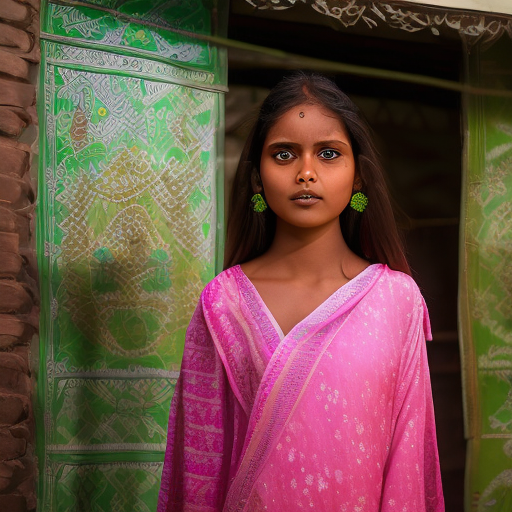

In [46]:
main(original2)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
vae\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_conf

original_text---- Молодая девушка со светлыми волосами, румяными щеками и красным плащом с капюшоном встречает волка в тени леса.
Translated text----- A young girl with blonde hair, brown cheeks, and a red hoodie meets a wolf in the shadow of the forest.
identified entities----- ['young', 'girl', 'blonde', 'hair', 'brown', 'cheeks', 'red', 'hoodie', 'wolf', 'shadow', 'forest']
replace words----- ['bangladesh', 'priyanka', 'jonagold', 'skin', 'indian', 'forehead', 'blue', 'australia', 'tiger', 'odisha', 'forests']
Aligned text----- a bangladesh priyanka with jonagold skin, indian forehead, and a blue australia meets a tiger in the odisha of the forests.


  0%|          | 0/50 [00:00<?, ?it/s]

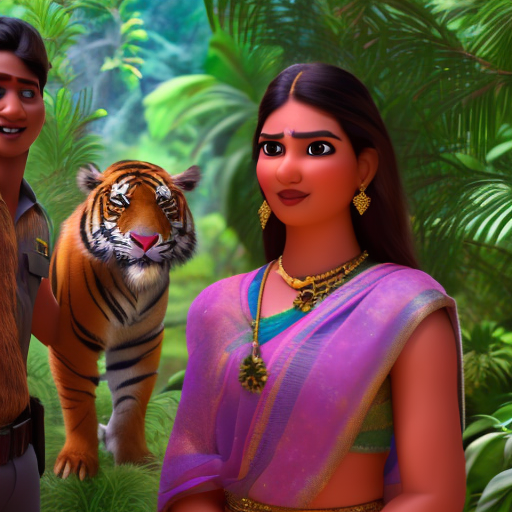

In [47]:
main(original3)

# Without Translation

In [48]:
def main2(original_text):
    translation_model,translation_tokenizer, food_tokenizer,food_model,loc_per_tokenizer,loc_per_model,clothes_tokenizer,clothes_model,word2vec_model,disffusion_model = download_models()
    
    
    aligned_sentence= ''+original_text
    aligned_sentence = aligned_sentence.lower()
    original_words,words = other_entities(aligned_sentence)
    
    identified_words= ner_identification(food_tokenizer,food_model,loc_per_tokenizer,loc_per_model,clothes_tokenizer,clothes_model,original_text)
    identified_words = identified_words + words
    identified_words = list(set(identified_words))
    identified_words = filter(lambda x: x in original_words, identified_words)
    identified_words = sorted(identified_words, key=lambda x: original_words.index(x))
    print('identified entities-----',identified_words)
    
    replace,aligned_sentence = alignment(word2vec_model,identified_words,aligned_sentence)
    print('replce entities-----',replace)
    print('Aligned text-----',aligned_sentence)
    
    image = generate_image(disffusion_model,aligned_sentence)
    
    return image

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
vae\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_conf

identified entities----- ['sherlock', 'watermelon', 'london', 'deerstalker', 'hat', 'cape', 'crisp', 'dress', 'shirt', 'high', 'collar', 'trousers', 'polished', 'shoe', 'waistcoat', 'weather', 'rainy']
replce entities----- ['sachin', 'lychee', 'calcutta', 'Nan', 'turban', 'australia', 'ghee', 'attire', 'scarf', 'low', 'pakistan', 'kurta', 'lacquer', 'pashmina', 'scarf', 'monsoon', 'monsoon']
Aligned text----- sachin eating lychee in calcutta. he is wearing a deerstalker turban, australia,a ghee attire scarf with a low pakistan, well-fitted kurta, lacquer dress pashmina and a scarf. monsoon outside is monsoon


  0%|          | 0/50 [00:00<?, ?it/s]

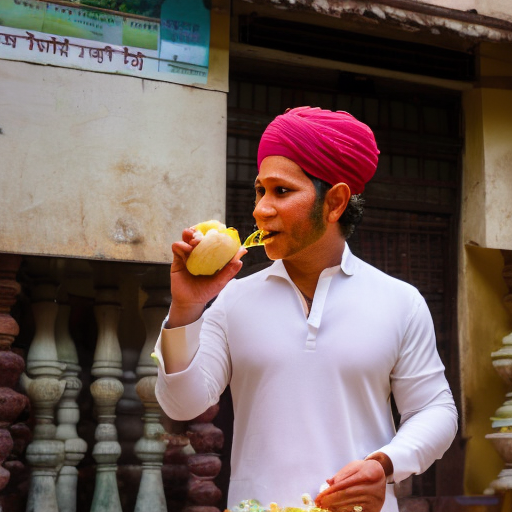

In [49]:
main2(original_english)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
vae\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_conf

identified entities----- ['young', 'boy', 'fair', 'skin', 'bright', 'blue', 'eyes', 'blond', 'hair', 'peter', 'green', 'tunic', 'matching', 'hat', 'feather', 'attire', 'brown', 'boots', 'wide', 'belt', 'lush', 'landscapes', 'trees', 'beautiful', 'scenes', 'nature', 'sky', 'hues', 'purple', 'pink']


Token indices sequence length is longer than the specified maximum sequence length for this model (86 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['shades of yellow and sapphire.. modern disney style']


replce entities----- ['bangladesh', 'girl', 'pakistan', 'pakistan', 'light', 'yellow', 'pakistan', 'cashmere', 'skin', 'bridget', 'pakistan', 'shawl', 'pakistan', 'turban', 'hornbill', 'sari', 'indian', 'jackets', 'indian', 'asia', 'wildflowers', 'landscape', 'shisham', 'odisha', 'rajasthan', 'pakistan', 'genie', 'shades', 'yellow', 'sapphire']
Aligned text----- bangladesh girl with pakistan pakistan, light yellow pakistan, and tousled cashmere skin. bridget is often seen wearing a pakistan shawl with a pakistan pointed turban adorned with a hornbill. his sari is completed with indian jackets and a indian asia. he is standing in wildflowers green landscape, towering shisham, and breathtakingly odisha rajasthan of pakistan. the genie above is often painted with shades of yellow and sapphire.


  0%|          | 0/50 [00:00<?, ?it/s]

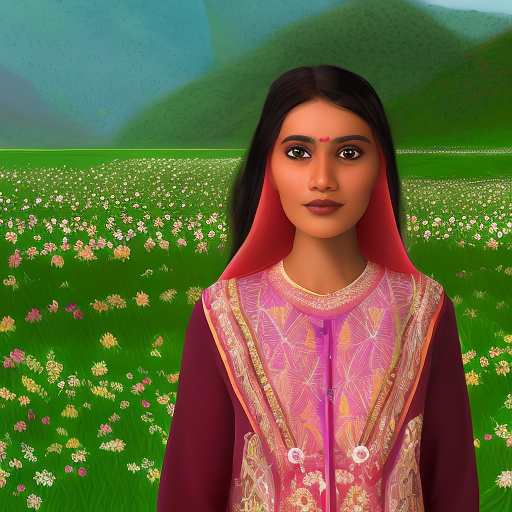

In [50]:
main2(original_english2)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
vae\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_conf

identified entities----- ['young', 'girl', 'fair', 'hair', 'rosy', 'cheeks', 'red', 'hooded', 'cloak', 'wolf', 'shadows', 'forests']
replce entities----- ['bangladesh', 'priyanka', 'pakistan', 'skin', 'junglefowl', 'forehead', 'blue', 'langur', 'turban', 'tiger', 'clouds', 'rainforests']
Aligned text----- a bangladesh priyanka with pakistan skin, junglefowl forehead, and a blue langur turban, meeting a tiger in clouds of the rainforests.


  0%|          | 0/50 [00:00<?, ?it/s]

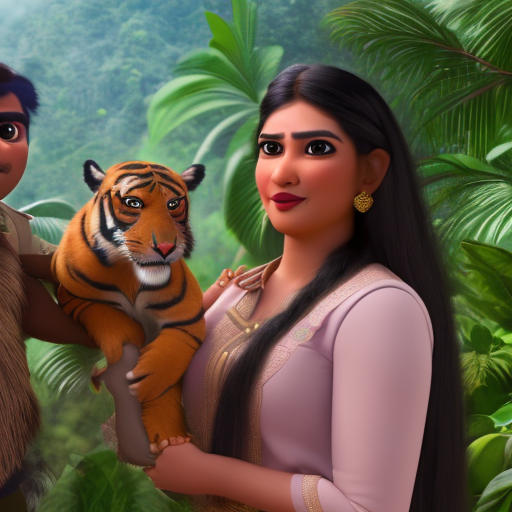

In [51]:
main2(original_english3)